In [2]:
# Подключаем используемые библиотеки
from scipy.fft import fft, ifft, fftshift
from scipy.linalg import solve
import matplotlib.pyplot as plt
import numpy as np

In [67]:
# @title 1) Спектральная плотность мощности входного сигнала
def input_signal(file_name: str) -> tuple:
  try:
    with open(file_name, 'r') as f:
      all_data = f.readlines()
      f.close()
      signal_str = all_data[0].split()
      fs = float(all_data[1])
      signal = list(map(complex, signal_str))
      return (fs, signal)
  except FileNotFoundError:
    print("Файл не найден в директории.")
    return 1


def autocorrelation(signal: list) -> list:
  signal = np.array(signal)
  n = len(signal)
  corr = [0] * (2 * n - 1)
  for k in range(1, n + 1):
    corr[k] = np.dot(signal[0 : k - 1], signal[n - k : n - 1].conjugate()) / n
  corr[n + 1 : 2 * n] = corr[n - 1 :: -1]

  return corr


def power_spec_density(sig: list) -> np.ndarray:
  corr_sig = autocorrelation(sig)
  return abs(fftshift(fft(corr_sig)))


def convert_complex_to_float(signal: list) -> None:
    for i in range(len(signal)):
      if signal[i].imag == 0:
        signal[i] = round(signal[i].real, 2)



def draw_power_spec_density(file_str: str) -> None:
  fs = file_str[0]
  sig = file_str[1]
  convert_complex_to_float(sig)
  period = 1 / fs
  psd = power_spec_density(sig)
  plt.title('Спектральная плотность мощности сигнала, Вт/Гц')
  plt.grid(True)
  f = [i * fs / len(psd) for i in range(len(psd))]
  plt.xlabel('частота, Гц')
  plt.stem(f, psd);

Введите название файла, откуда будем считывать сигнал: 
test1.txt


<ipython-input-68-6a95278f0eed>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


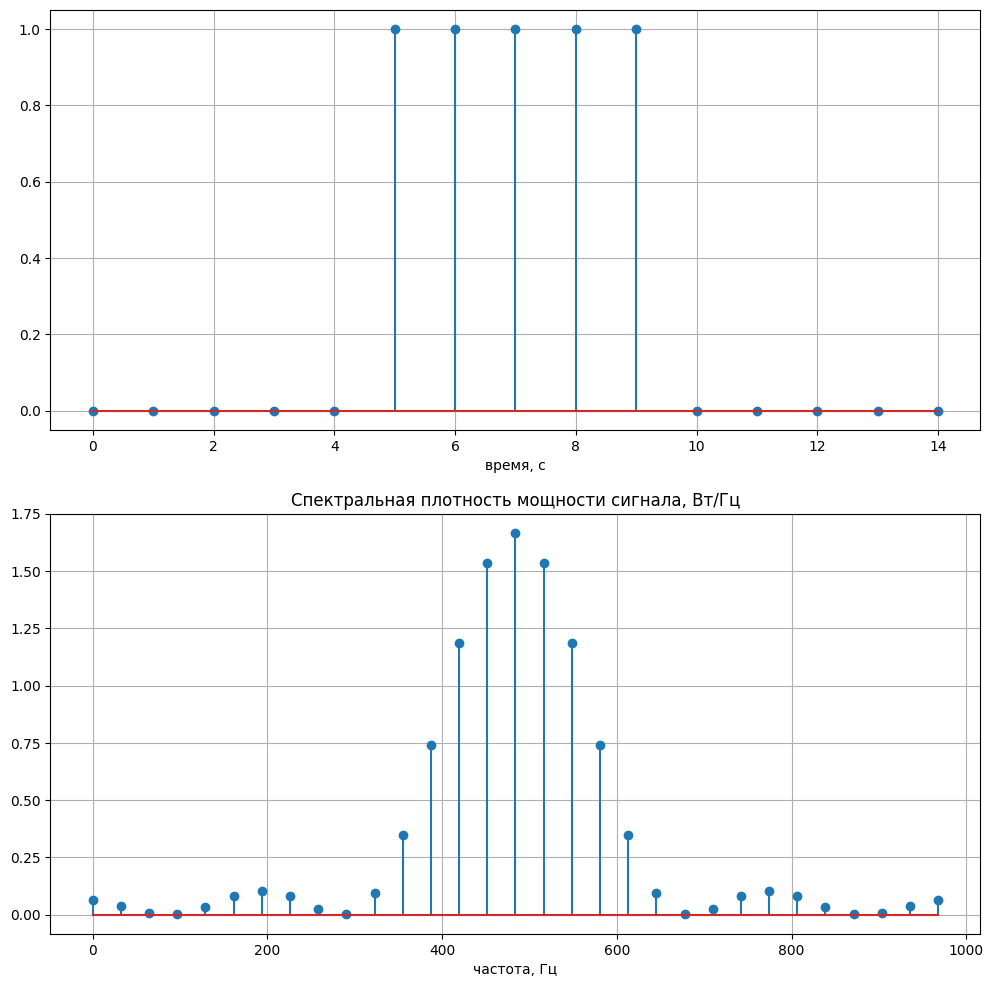

In [68]:
# Отобразим спектральную плотность мощности сигнала
print("Введите название существующего файла, откуда будем считывать сигнал: ")
file = input()
sig_str = input_signal(file)
if sig_str != 1:
  plt.subplots(figsize=(12, 12))
  plt.subplot(2, 1, 1)
  plt.grid(True)
  sig = sig_str[1]
  convert_complex_to_float(sig)
  plt.stem(sig);
  plt.xlabel('время, с')
  plt.subplot(2, 1, 2)

  draw_power_spec_density(sig_str)

In [6]:
# @title 3) Полосовой(Baseband) частотный фильтр входного сигнала
# Фильтр приподнятого косинуса (способствует нулевой межсимвольной интерференции)
def rc_coeff(span: int, nsamp : int, rolloff: float) -> list:
    res = [0] * (span * nsamp // 2 + 1)
    t = [i for i in range(span * nsamp // 2 + 1)]
    res[0] = 1 / np.sqrt(nsamp);

    for i in range(1, len(t)):
        if t[i] == nsamp / (2 * rolloff):
            res[i] = 1 / np.sqrt(nsamp) * rolloff / 2 * np.sin(np.pi / (2 * rolloff))
        else:
            res[i] = 1 / np.sqrt(nsamp) * np.sin(np.pi * t[i] / nsamp) / (np.pi * t[i] / nsamp) * np.cos(np.pi * rolloff * t[i] / nsamp) / (1 - 4 * (rolloff * t[i] / nsamp) ** 2)
    inres = res[::-1]

    rc = [0] * (span * nsamp + 1)

    for i in range(span * nsamp // 2 + 1):
        rc[i] = inres[i]

    for i in range(1, span * nsamp // 2 + 1):
        rc[span * nsamp // 2 + i] = res[i]

    return rc


<ipython-input-69-56b8f04a01b0>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


Text(0.5, 0, 'отсчёты по частоте')

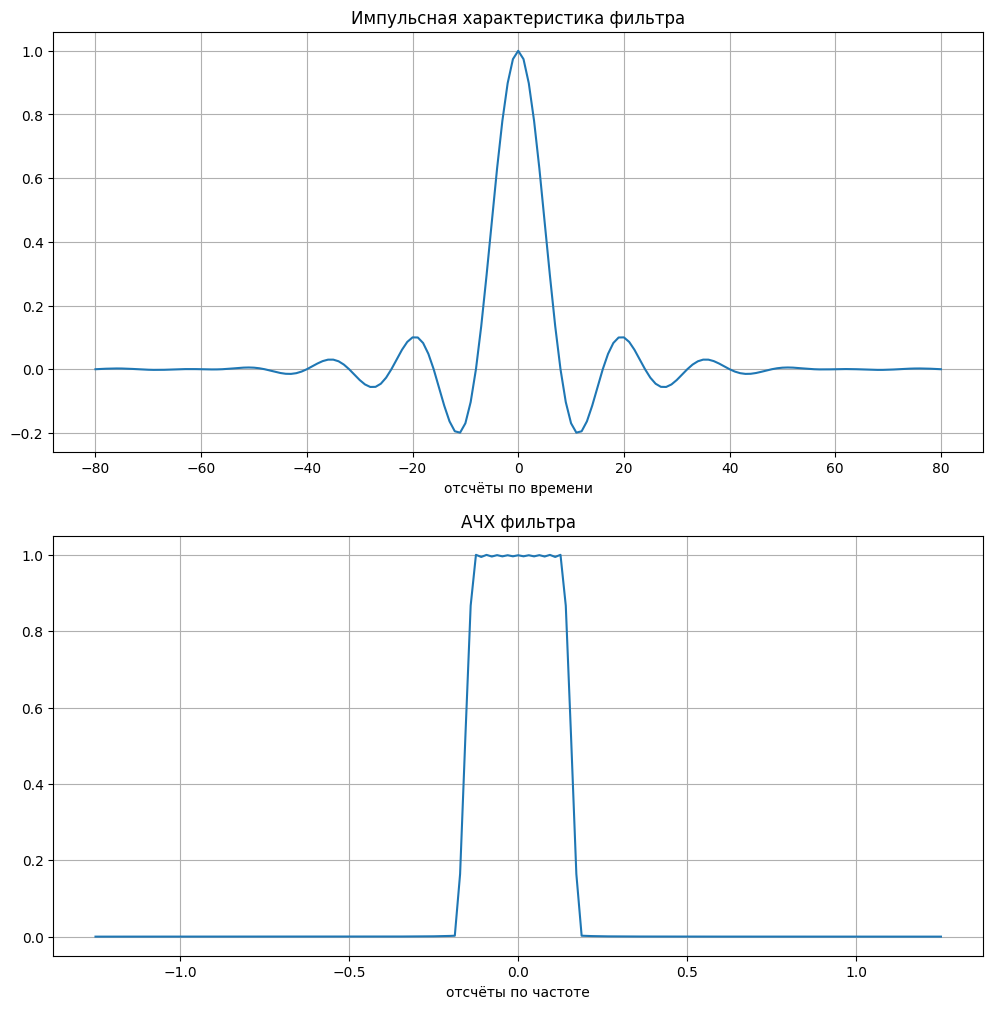

In [69]:
# Filter parametres
span = 20
nsamp = 8
rolloff = 0.2

y = rc_coeff(span, nsamp, rolloff)

plt.subplots(figsize=(12, 12))
plt.subplot(2, 1, 1)
x1 = [i for i in range(-span * nsamp // 2, span * nsamp // 2 + 1)]
plt.plot(x1, np.array(y) / max(y));
plt.grid(True)
plt.title("Импульсная характеристика фильтра")
plt.xlabel("отсчёты по времени")

plt.subplot(2, 1, 2)
x2 = np.linspace(-span / (2 * nsamp), span / (2 * nsamp), span * nsamp + 1)
afr = abs(fftshift(fft(y)))
plt.plot(x2, np.array(afr) / max(np.array(abs(fftshift(fft(y))))));
plt.grid(True)
plt.title("АЧХ фильтра")
plt.xlabel("отсчёты по частоте")

In [70]:
# amplitude-frequency response of the signal after baseband filtration
def filtration(signal: list, afr: list) -> list:
  fft_signal = fftshift(fft(signal))
  new_afr = afr + [0] * (len(signal) - len(afr))
  res = [new_afr[i] * fft_signal[i] for i in range(len(signal))]

  return np.array(res)

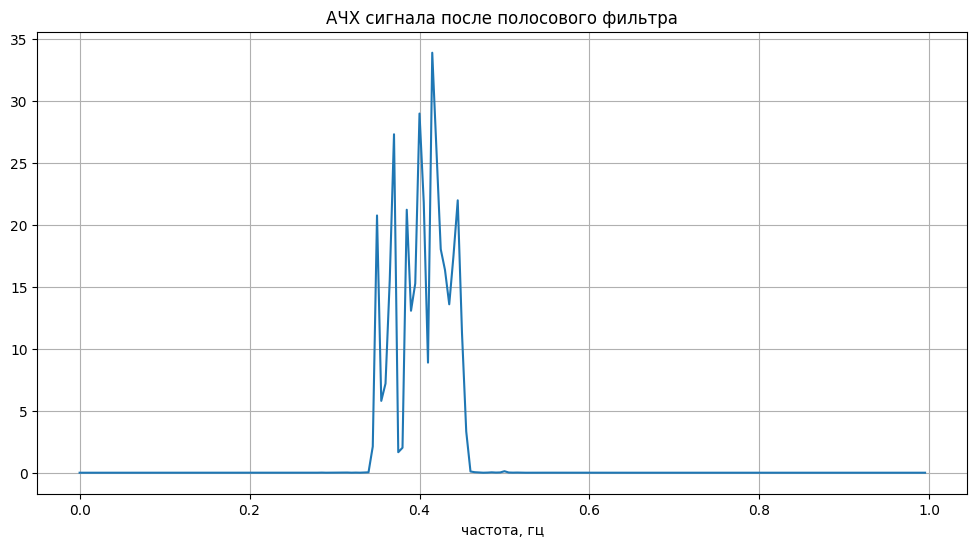

In [71]:
# generating binary signal from uniform distribution
np.random.seed(42)
count = 200
sig = list(np.random.randint(0, 2, count))
afr = list(afr)
filt = abs(filtration(sig, afr))
fs = 1  # sampling frequency
t = [i * fs / len(filt) for i in range(len(filt))]

plt.subplots(figsize=(12, 6))
plt.plot(t, filt)
plt.xlabel("частота, гц")
plt.title("АЧХ сигнала после полосового фильтра")
plt.grid(True)

In [77]:
def write_signal_to_file(newsignal: list, fs: float) -> int:
  # convert_complex_to_float(newsignal)
  for i in range(len(newsignal)):
    newsignal[i] = complex(round(newsignal[i].real, 2), round(newsignal[i].imag, 2))
  print("Введите название файла, куда будем записывать результат: ")
  output_file = input()  # путь до выходного файла
  try:
    with open(output_file, 'w') as new_file:
      s = ' '.join(map(str, newsignal))
      new_file.write(s + '\n')
      new_file.write(str(fs))
      new_file.close()
      return 1
  except FileNotFoundError:
    print("Файл не найден в директории.")
    return 0

<ipython-input-73-f2635526f993>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


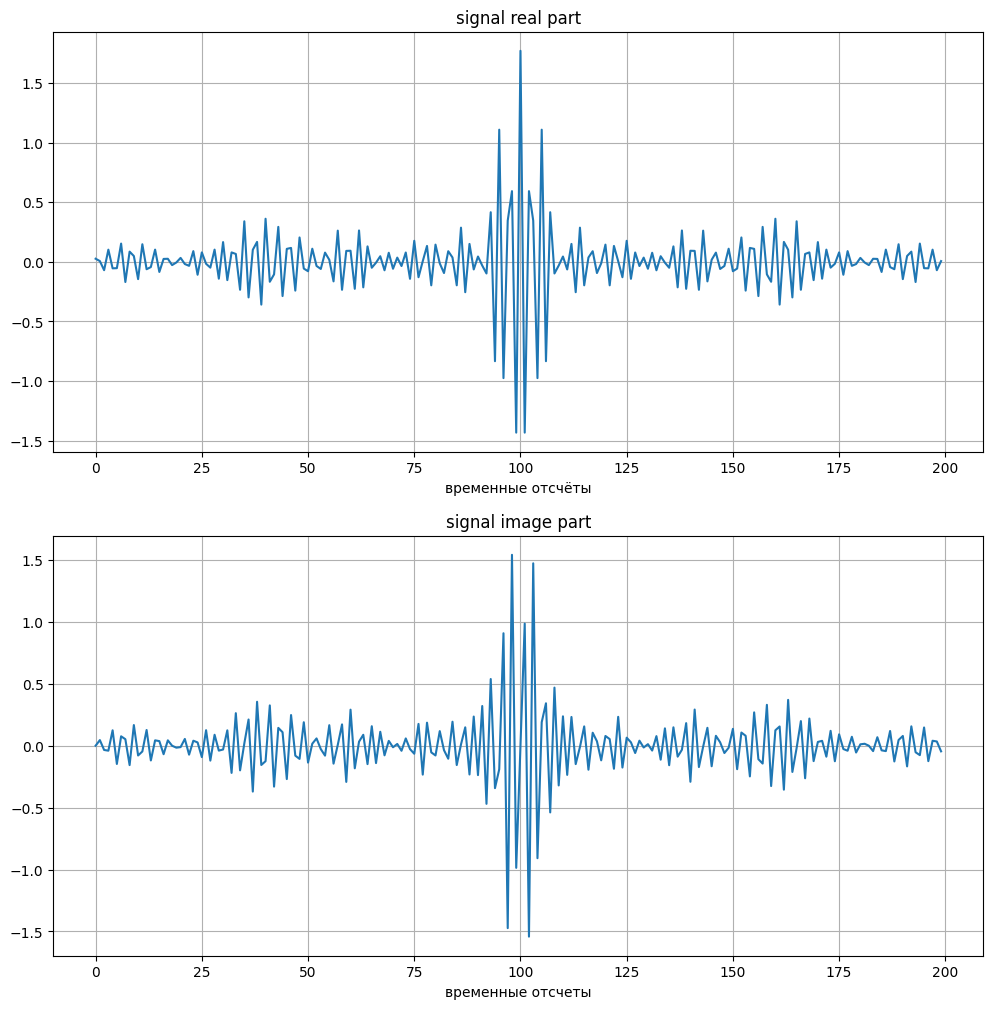

In [73]:
# output signal
sig_aft_filt = fftshift(ifft(filt))

plt.subplots(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(sig_aft_filt.real);
plt.title("signal real part")
plt.xlabel("временные отсчёты")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(sig_aft_filt.imag);
plt.title("signal image part")
plt.xlabel("временные отсчеты")
plt.grid(True)

# sig_aft_filt

In [79]:
# writing signal to .txt file
flag = write_signal_to_file(sig_aft_filt, fs)
if flag == 1:
  print("Результат успешно записан в файл")

Введите название файла, куда будем записывать результат: 
signal_after_filt.txt
Результат успешно записан в файл


In [75]:
# @title 6) Передискритизатор сигнала (применяем интерполяционный полином Лагранжа)
def signal_resampler(signal: list, sample_count: int, fs_old: float, fs_new: float) -> list:
  koeff = fs_new / fs_old
  x = [i / (koeff * fs_old) for i in range(sample_count)]  # samples of new signal
  s = np.array(signal)
  n = len(signal)
  M = np.zeros((n, n))
  for i in range(n):
    for j in range(n):
      M[i][j] = i ** j

  a = solve(M, s)
  new_signal = [0] * sample_count
  for i in range(sample_count):
    res = 0
    for j in range(n):
      res += a[j] * (x[i] ** j)
    new_signal[i] = res

  return new_signal


In [63]:
# @title 4) Сумматор сигналов с применением передискритизации
# return the sum of 2 signals with different sampling rates(fs)
def summ_signals(file_name1: str, file_name2: str) -> tuple:
  data1 = input_signal(file_name1)
  data2 = input_signal(file_name2)
  fs1 = data1[0]
  fs2 = data2[0]
  sig1 = data1[1]
  sig2 = data2[1]
  res = []
  if fs1 == fs2:
    if len(sig1) != len(sig2):
      if len(sig1) > len(sig2):
        ost = [0] * (len(sig1) - len(sig2))
        sig2.extend(ost)
      else:
        ost = [0] * (len(sig2) - len(sig1))
        sig1.extend(ost)

    res = [sig1[i] + sig2[i] for i in range(len(sig1))]

  else:
    if fs2 > fs1:
      res = signal_resampler(sig1, len(sig2), fs1, fs2)
    else:
      res = signal_resampler(sig2, len(sig1), fs2, fs1)

  return (res, max(fs1, fs2))

In [84]:
print("Введите названия существующих файлов с входными данными: ")
s = input().split()
res_sig = summ_signals(s[0], s[1])
sig = res_sig[0]
fs = res_sig[1]
convert_complex_to_float(sig)
flag = write_signal_to_file(sig, fs)
if flag == 1:
  print("Результат успешно записан в файл")

Введите названия файлов с входными данными: 
test1.txt test2.txt
Введите название файла, куда будем записывать результат: 
summ_signals.txt
Результат успешно записан в файл


In [85]:
# @title 5) Генератор аддитивного белого гауссовского шума
# snr[dB] = 10 * log10(Psig / Pnoise) = 20 * log10(Asig / Anoise)
def mean_sig_power(signal: list) -> float:
  p = 0
  for i in range(len(signal)):
    p += signal[i] ** 2
  res = p / len(signal)

  return res


# generating AWGN noise
def white_noise_generator(signal: list, snr: float) -> np.ndarray:
  np.random.seed(42)
  p_sig = mean_sig_power(signal)
  p_mean_noise = p_sig / 10 ** (snr / 10)
  a_mean_noise = p_mean_noise ** 0.5
  noise = a_mean_noise * np.random.normal(0, 1, len(signal))

  return noise


def noised_signal(signal: list, snr: float) -> np.ndarray:
  signal = np.array(signal)
  noise = white_noise_generator(signal, snr)
  noised_sig = signal + noise

  return noised_sig

In [87]:
print("Введите название существующего файла, откуда будем считывать сигнал: ")
file = input()
sig_str = input_signal(file)
sig = sig_str[1]
fs = sig_str[0]

Введите название существующего файла, откуда будем считывать сигнал: 
test1.txt


In [89]:
print("Введите отношение сигнал/шум (SNR)[dB]: ")
snr = float(input())  # dB
ns = noised_signal(sig, snr)
convert_complex_to_float(ns)
flag = write_signal_to_file(ns, fs)
if flag == 1:
  print("Результат успешно записан в файл")

Введите отношение сигнал/шум (SNR)[dB]: 
15
Введите название файла, куда будем записывать результат: 
noised_signal.txt
Результат успешно записан в файл


<ipython-input-92-86ed850bb5d3>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


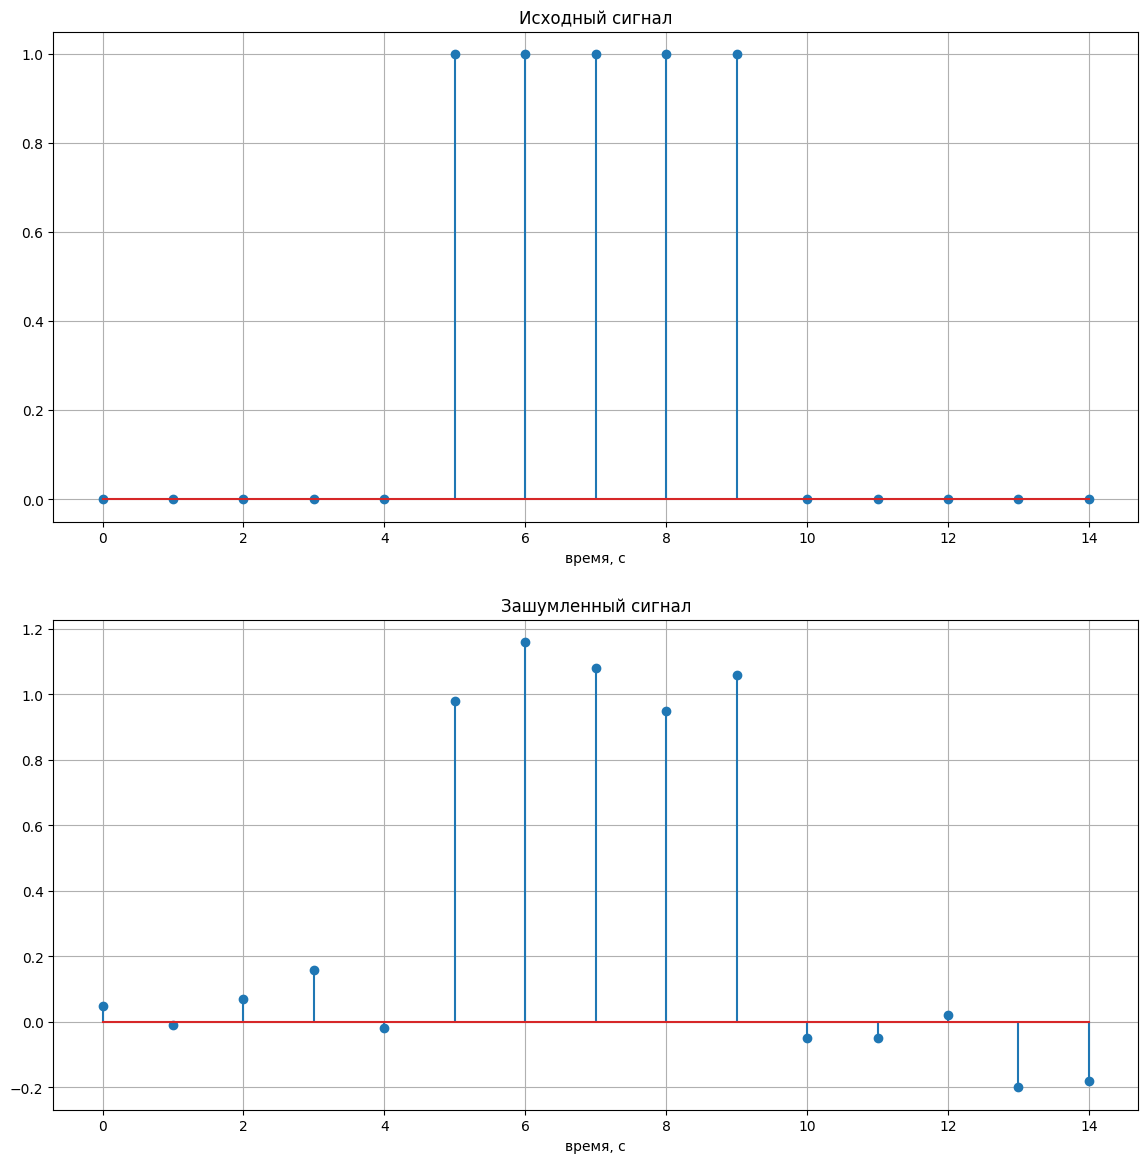

In [92]:
plt.subplots(figsize=(14, 14))
plt.subplot(2, 1, 1)
plt.grid(True)
convert_complex_to_float(sig)
plt.stem(sig);
plt.xlabel('время, с')
plt.title("Исходный сигнал");

plt.subplot(2, 1, 2)
plt.grid(True)
convert_complex_to_float(ns)
plt.stem(ns);
plt.xlabel('время, с')
plt.title("Зашумленный сигнал");

In [93]:
# noise level analysis
def mse(signal: list, noised_signal: list) -> float:
  n = len(signal)
  res = 0
  for i in range(n):
    res += (signal[i] - noised_signal[i])**2

  return res / n

Text(0, 0.5, 'MSE')

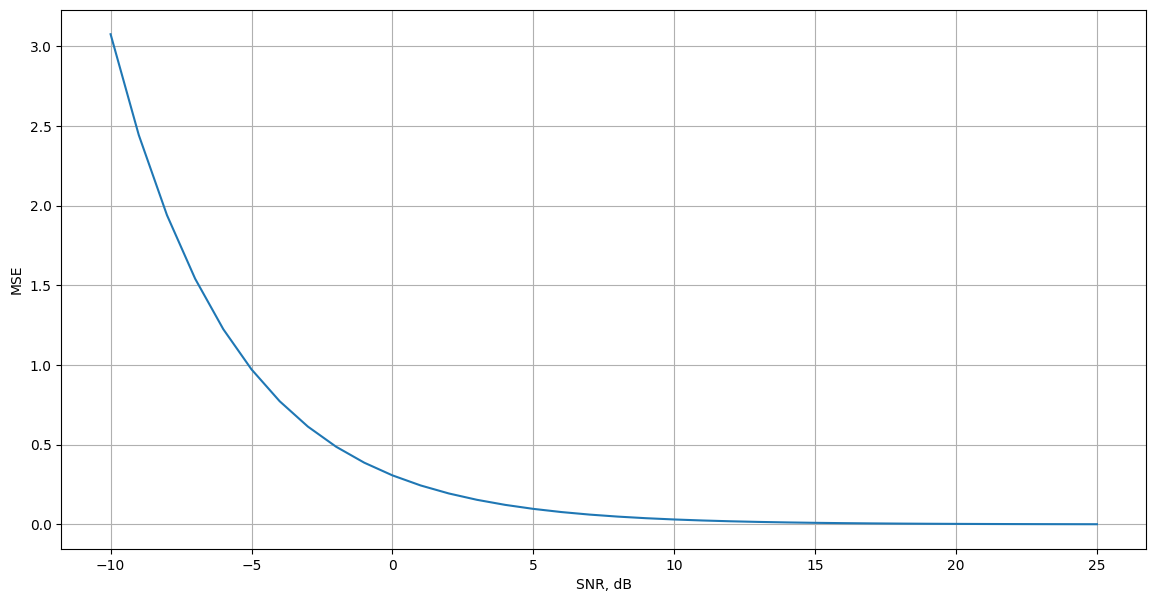

In [94]:
# mse(snr)
snrs = np.linspace(-10, 25, 36)
mses = [0] * len(snrs)
plt.subplots(figsize=(14, 7))
plt.grid(True)
for i in range(len(snrs)):
  convert_complex_to_float(sig)
  n_sig = noised_signal(sig, snrs[i])
  y = mse(sig, n_sig)
  mses[i] = y
plt.plot(snrs, mses);
plt.xlabel("SNR, dB")
plt.ylabel("MSE")